### Environment Setup

Clone project-azua from the git-repo:

In [1]:
# !git clone https://github.com/microsoft/project-azua.git

**Set-up Python environement**: Create a new conda environemnt following the [instruction](https://github.com/microsoft/project-azua#2-getting-started) on the git-repo.

**AzureML**: If you are working on Azure Machine Learning, [this link](https://medium.com/analytics-vidhya/how-to-create-virtual-environments-in-azure-ml-workspace-in-azure-portal-39245a34b370) helps you with creating a new environment.

### Import Packages

In [2]:
import sys
sys.path.append('.')
sys.path.append("../../project-azua") # appending the project-azua git-repo path; modify based on where you downloaded the repo
sys.path.append("../../project-azua/azua")
sys.path.append("helpers")

In [3]:
# python pkgs
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# local helper functions
from helpers.dataprep_utils import compute_missing_ratio, get_variables_metadata

### EDDI-Azua Setup

In [5]:
# azua pkgs
from azua.experiment.steps.step_func import load_data
from azua.models.partial_vae import PartialVAE
from azua.experiment.steps.active_learning_step import run_active_learning_main
from azua.experiment.azua_context import AzuaContext
from azua import models  # type: ignore

In [6]:
# load configs from config-files
dataset_config = json.load(open("config/dataset_config.json"))

configs = json.load(open("config/model_config_pvae.json"))
model_config = configs["model_config"]
training_params = configs["training_params"]
impute_config = configs["impute_config"]
objective_config = configs["objective_config"]

In [7]:
# load Azua Context
azua_context = AzuaContext()
azua_context.wire(modules=[sys.modules[__name__]], packages=[models])

### Load datasets
We load the dataset, select the columns that we want. Then save it without header and index to our data-path (data/generated). We can either store the full dataset named all.csv and let the model decide train/test portions, or we can explictly store them under train.csv and test.csv and setup the "use_predefined_dataset" to true in dataset_config.json file. 

In [8]:
df = pd.read_csv('./data/generated/sensor_wide.csv', index_col='time')
df.head(2)

,IN1,IN2,IN3,IN4,IN5,IN6,IN7,IN8,Out1,Out2
time,,,,,,,,,,
0,0.077744,0.795565,-0.665503,0.879321,0.134419,-0.889633,1.620600,-0.158693,-0.122686,0.123661
1,0.080313,0.824595,-0.655447,0.875636,0.134941,-0.429724,0.742982,0.324297,-0.122686,0.123661


In [9]:
df.to_csv('./data/generated/all.csv', index=False, header=False)
dataset_config["use_predefined_dataset"] = False

We use the load_data function to create the train and test datasets; note that these files do not have any index or header.

In [10]:
# Load the dataset 
dataset = load_data("generated", "./data", 0, dataset_config, model_config, tiny=False)

Minimum value of variable Column 0 inferred as -2.6966462468768704. This can be changed manually in the dataset's variables.json file
Max value of variable Column 0 inferred as 1.59063874771148. This can be changed manually in the dataset's variables.json file
Variable Column 0 inferred to be a queriable variable. This can be changed manually in the dataset's variables.json file by updating the "query" field.
Variable Column 0 inferred as not an active learning target variable. This can be changed manually in the dataset's variables.json file by updating the "target" field.
Variable Column 0 inferred as not an always observed target variable. This can be changed manually in the dataset's variables.json file by updating the "always_observed" field.
Minimum value of variable Column 1 inferred as -3.4379855789852596. This can be changed manually in the dataset's variables.json file
Max value of variable Column 1 inferred as 1.9396385112663799. This can be changed manually in the dataset's

In [11]:
# You see the missing parts are filled with zeros but they are reflected on mask-matrix
train_data = pd.DataFrame(dataset._train_data)
train_data.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.0777441,0.795565,-0.665503,0.879321,0.134419,-0.889633,1.6206,-0.158693,-0.122686,0.123661
1,0.0803125,0.824595,-0.655447,0.875636,0.134941,-0.429724,0.742982,0.324297,-0.122686,0.123661
2,0.0873549,0.776258,-0.65055,0.884105,0.132452,-1.42411,1.24156,-0.0556637,-0.026857,0.123661
3,0.0917736,0.739149,-0.644934,0.892043,0.131287,-0.113311,0.323872,-0.737709,-0.026857,0.25101
4,0.0911661,0.761332,-0.648654,0.892752,0.136788,-0.552131,0.0931013,-0.720496,-0.026857,0.25101
5,0.0876587,0.762017,-0.653656,0.896012,0.140481,-0.67941,1.1874,0.53594,-0.026857,0.378358
6,0.0824943,0.733398,-0.653621,0.892469,0.138193,-0.0866311,1.1315,0.855154,-0.026857,0.378358
7,0.0818867,0.703957,-0.650796,0.891512,0.13751,-0.710141,1.65294,0.0431604,0,0.505707
8,0.0848141,0.637956,-0.654587,0.888535,0.135382,-0.143551,-0.2104,0.31016,-0.026857,0.505707
9,0.0840408,0.668218,-0.654516,0.889315,0.130926,-1.11735,1.60252,-0.214553,-0.026857,0.633055


In [12]:
# You can see the missing parts are marked as False
pd.DataFrame(dataset._train_mask).head(10)

,0,1,2,3,4,5,6,7,8,9
0,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,False,True
8,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True


### Train model

Here we create n_seed number of different models, one for each seed. By default n_seed = 1, so we are only showing result for single model.

In [13]:
model_dir = "pvae_model"
n_seed = 1 # number of re-runs; we can do multiple runs, if we need to do hyperparameter-tuning. 

In [14]:
model = [None] * n_seed
for i in range(n_seed):
    print(f'training {i+1}th model')
    model_config['random_seed'] = i
    model[i] = PartialVAE.create("mymodel", os.path.join(model_dir, 'model_' + str(i)), 
                                 dataset.variables, model_config, device = "cpu") # change cpu to cuda if you are running on VMs
    model[i].run_train(dataset, training_params)

training 1th model


../../project-azua/azua/utils/data_mask_utils.py:25: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return tuple(torch.as_tensor(array, dtype=dtype, device=device) for array in arrays)


### Missing data imputation

Load the dataset and masks and run the imputation:

In [16]:
df_all = pd.read_csv('./data/generated/all.csv', names=df.columns)

In [17]:
all_mask = np.array(df.isna())

In [18]:
all_data = np.array(df_all)


In [21]:
df.isna().head(10)

,IN1,IN2,IN3,IN4,IN5,IN6,IN7,IN8,Out1,Out2
time,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,False,False,False,False,False,False


In [22]:
# impute dataset
imputed = model[0].impute(all_data, all_mask, impute_config)

100%|██████████| 145/145 [00:00<00:00, 159.90it/s]


In [23]:
df_all_imputed = pd.DataFrame(imputed, columns=df.columns).head(10)
df_all_imputed.to_csv('./data/prepared/prep_sensor_data.csv')

### Quick Evaluation

Visualize performance based on the columns we have ground-truth

In [24]:
# load ground-truth data
data_gt = pd.read_csv("data/original/all.csv", index_col=0)
eval_cols = data_gt.columns # we don't have ground-truth for the noisy columns

# only evaluate cols we have ground-truth for
eval_cols_index = [df.columns.get_loc(col) for col in eval_cols]
imputed_gt = imputed[:, eval_cols_index]
all_mask_gt = all_mask[:, eval_cols_index]
data_gt = np.array(data_gt)

[Text(0.5, 0, 'True value'), Text(0, 0.5, 'Imputed value')]

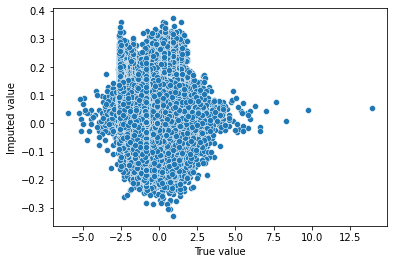

In [25]:
%matplotlib inline
ax = sns.scatterplot(x=data_gt[all_mask_gt==0].astype(np.float), y=imputed_gt[all_mask_gt==0].astype(np.float))
ax.set(xlabel="True value", ylabel="Imputed value")